# Capstone Project - Beer and a Beardtrim: Where to locate a premium service Men's Salon/Barbershop


### Applied Data Science Capstone by IBM/Coursera



## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find the best zip code(s) in which to open a premium services men's hair salon in San Antonio, Texas.  This is the type of barbershop where customer's pay a premium for stellar atmosphere, styling, and service.  Indicative of this type of business is that it is typical that beer or other types of alcohol are given away as 'part of the service.'

Selecting the best zip code to open this type of business allows a potential client to narrow down their search for a commercial storefront to the most promising places.  The criteria that we are looking for in determining the best zip codes are as follows:

1. This business should open to a location nearby to its potential clientele.  While this is obvious, it then begs the question, "What is this type of business' likely clientele?"
2. This business' clientele will be male clients who can afford a premium haircut experience.  Therefore, zip codes where median and average income of residents are higher make better prospective locations than zip codes where income is lower.
3. Additionally, our clientele will not just have higher incomes, but also higher "disposable" incomes as well.  We would like to select locations where the nearby residents are more likely to be young and without children.
3. Competition is a major factor in determining the right zip code as well.  While a premium barbershop will be in a niche that doesn't directly compete with standard service barber shops, we want to avoid locating close by other premium barbershops.

We will use our data science powers to generate the best locations for this business by zip code based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* The economic indicators of a particular zip code  (income of the residents and business activity)
* The average family size of the residents of a particular zip code (Social Indicator)
* The presence of other premium men's salons first, and then the presence of ordinary barber shops.


Our location data will organized by zip code because US Census Data and other types of demographic information collection are often organized by zip code.  This provides us with data that tells us the income and family size data of the residents of a particular zip code.

Following data sources will be needed to extract/generate the required information:
* A list of zip codes for Texas and their boundaries.  This data was pulled opensource from github.  Special thanks to user 'enactdev' for posting the GEOJSON
* Demographic data by zip code will be pulled using the **Zip-codes.com API**
* The list of zip codes applicable to San Antonio, TX will also be pulled from **Zip-codes.com.**
* number of men's salons / barbershops in a given zip code will be obtained using the  **Foursquare API**


### Data Gathering: List of Zip Codes

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

filename = 'Zip Codes San Antonio.csv' #I copied and pasted this data into CSV format from: 
# "https://www.zip-codes.com/city/tx-san-antonio.asp#zipcodes"

table = pd.read_csv(filename)
table.head() #all tables displayed as head(10) for cleaner HTML presentation

ZIP Code      Type County Population Area Code(s)
0  ZIP Code 78201  Standard  Bexar     45,307          210
1  ZIP Code 78202  Standard  Bexar     11,691          210
2  ZIP Code 78203  Standard  Bexar      6,099          210
3  ZIP Code 78204  Standard  Bexar     11,125          210
4  ZIP Code 78205  Standard  Bexar      1,453    210 / 726

Let's clean this data.  
* We don't need the Area Codes
* We don't need the County
* We should eliminate the PO BOX only zip codes
* We should change the string for Zip Code to only reflect the numbers

In [2]:
ZipCodes = table # Names the df
ZipCodes1 = ZipCodes.drop(columns = ['Area Code(s)','County']) #Drop the Area Code and County Columns

indexnames = ZipCodes1[ZipCodes1['Type'] == 'P.O. Box' ].index #ID the P.O box Zip Codes

ZipCodes2 = ZipCodes1.drop(indexnames) #Drop Zip codes that are PO Box only

indexnames = ZipCodes2[ZipCodes2['Population'] == '0'].index

ZipCodes3 = ZipCodes2.drop(indexnames) #Drop Zip Codes where population equals zero


In [3]:
print(ZipCodes3['ZIP Code'].nunique()) #Verify no duplicates
print(ZipCodes3['Type'].nunique()) #Verify all Zip Codes are standard type

61
1


In [4]:
ZipCodes3['ZIP Code'] = ZipCodes3['ZIP Code'].str.replace('ZIP Code ','',regex=True)  #Format Zip Codes as integers

ZipCodes4 = ZipCodes3.drop(columns = 'Type') #Now that all zip code types are standard, we no longer need this column

ZIPlist = ZipCodes4['ZIP Code'].to_list()

### Data Gathering: Zip Code GEOJSON and Building an initial map

For the GEOJSON, I downloaded the file opensource from Github, and placed it in my working directory.  Thanks enactdev!
Source URL https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/tx_texas_zip_codes_geo.min.json

Now that we have the relevant zip codes and a GeoJSON of the Zip Codes shape, we have most of the data we need to create a map of our initial search area.  Let's grab the lat/long for San Antonio TX

In [5]:
# use the geolocator to get a center latlong for San Antonio

from geopy.geocoders import Nominatim

address = 'San Antonio, TX'

geolocator = Nominatim(user_agent="SATX_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Antonio are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Antonio are 29.4246002, -98.4951405.


For our map, we don't want to include Zip Codes outside of San Antonio.  So let's change our texas zip codes JSON to a San Antonio Zip Codes JSON.  I'm going to use mapshaper.org to help me do this.  

The command interface for the mapshaper tool requires the a string to filter the original JSON to a new JSON file.  I'll use python to build that string for me.  I want the tool to 'filter' the ZIP Codes that are not part of my above dataframe so ultimately my command to the system ends up being "filter + "string"

In [6]:
output=[] #initialize a list

for i in range(0,61):
    
    txt = 'ZCTA5CE10 == "{ZIP}"||'.format(ZIP = ZipCodes4.iloc[i,0])
    output.append(txt)

    
string = "".join(output) #converts the list of strings into a single string
string

'ZCTA5CE10 == "78201"||ZCTA5CE10 == "78202"||ZCTA5CE10 == "78203"||ZCTA5CE10 == "78204"||ZCTA5CE10 == "78205"||ZCTA5CE10 == "78207"||ZCTA5CE10 == "78208"||ZCTA5CE10 == "78209"||ZCTA5CE10 == "78210"||ZCTA5CE10 == "78211"||ZCTA5CE10 == "78212"||ZCTA5CE10 == "78213"||ZCTA5CE10 == "78214"||ZCTA5CE10 == "78215"||ZCTA5CE10 == "78216"||ZCTA5CE10 == "78217"||ZCTA5CE10 == "78218"||ZCTA5CE10 == "78219"||ZCTA5CE10 == "78220"||ZCTA5CE10 == "78221"||ZCTA5CE10 == "78222"||ZCTA5CE10 == "78223"||ZCTA5CE10 == "78224"||ZCTA5CE10 == "78225"||ZCTA5CE10 == "78226"||ZCTA5CE10 == "78227"||ZCTA5CE10 == "78228"||ZCTA5CE10 == "78229"||ZCTA5CE10 == "78230"||ZCTA5CE10 == "78231"||ZCTA5CE10 == "78232"||ZCTA5CE10 == "78233"||ZCTA5CE10 == "78234"||ZCTA5CE10 == "78235"||ZCTA5CE10 == "78236"||ZCTA5CE10 == "78237"||ZCTA5CE10 == "78238"||ZCTA5CE10 == "78239"||ZCTA5CE10 == "78240"||ZCTA5CE10 == "78242"||ZCTA5CE10 == "78243"||ZCTA5CE10 == "78244"||ZCTA5CE10 == "78245"||ZCTA5CE10 == "78247"||ZCTA5CE10 == "78248"||ZCTA5CE10


Output from the mapshaper website was the file SATX_zip_codes_geo.json.  This was placed in the folder along with this notebook

In [7]:
import folium

SAmap = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.GeoJson(
    'SATX_zip_codes_geo.json',
    name='geojson1'
).add_to(SAmap)

folium.LayerControl().add_to(SAmap)

SAmap

So now we have 2 of our 4 data requirements completed: The list of San Antonio Zip Codes and their boundaries and the ability to map those.  Now lets use the Zip-codes.com API to pull demographics for each zip code.

In [8]:
#Set up a test API request
key = 'VUX9CRM7QCX7Y5FKR7SS'
ZIPc = '78201'
URL = 'https://api.zip-codes.com/ZipCodesAPI.svc/1.0/GetZipCodeDetails/{ZIPcode}?key=<{KEY}>'.format(ZIPcode = ZIPc, KEY=key)
URL

'https://api.zip-codes.com/ZipCodesAPI.svc/1.0/GetZipCodeDetails/78201?key=<VUX9CRM7QCX7Y5FKR7SS>'

In [9]:
import requests
from pandas import json_normalize

result = requests.get(URL).json()
sample = json_normalize(result)
sample.columns.to_list()


['item.ID',
 'item.CountiesArea',
 'item.ZipCodePopulation',
 'item.HouseholdsPerZipcode',
 'item.WhitePop',
 'item.BlackPop',
 'item.HispanicPop',
 'item.AsianPop',
 'item.IndianPop',
 'item.HawaiianPop',
 'item.OtherPop',
 'item.MalePop',
 'item.FemalePop',
 'item.PersonsPerHousehold',
 'item.AverageHouseValue',
 'item.IncomePerHousehold',
 'item.MedianAge',
 'item.MedianAgeMale',
 'item.MedianAgeFemale',
 'item.AverageFamilySize',
 'item.Bus03Establishments',
 'item.Bus03Employment',
 'item.Bus03PayrollQuarter1',
 'item.Bus03PayrollAnnual',
 'item.Bus03EmploymentFlag',
 'item.CBSAPop2003',
 'item.CBSADivPop2003',
 'item.DeliveryActive',
 'item.DeliveryBusiness',
 'item.DeliveryResidential',
 'item.DeliverySpecial',
 'item.DeliveryBox',
 'item.DeliverySFDU',
 'item.DeliveryMFDU',
 'item.PopulationEstimate',
 'item._109thDistrict',
 'item._109thArea',
 'item._110thDistrict',
 'item._110thArea',
 'item.GrowthRank',
 'item.GrowthHousingUnits2003',
 'item.GrowthHousingUnits2004',
 'item.

Our sample result returns 103 columns, so lets see if we can slice the information we need.
* The first group of columns look like demographic data thats useful. Index 1 to 'item.Bus03PayrollQuarter1' would be useful.
*item.ZipCode is necessary as well
*Latitute, Longitude and AreaLand(Land Area) would be useful also

So lets systematically discover which columns we need to grab from the results for later.

In [10]:
filtered_columns = ['item.ZipCode', 
                    'item.Latitude', #basic location data
                    'item.Longitude', #basic location data
                    'item.AreaLand',  #used later to compute population density,
                    'item.ZipCodePopulation', #used later to compute population density,
                    'item.AverageHouseValue', #Economic Indicator
                    'item.IncomePerHousehold', #Economic Indicator
                    'item.Bus03Establishments', #Economic Indicator
                    'item.Bus03Employment', #Economic Indicator
                    'item.Bus03PayrollAnnual', #Economic Indicator
                    'item.MedianAge', #Social Indicator
                    'item.MedianAgeMale', #Social Indicator
                    'item.MedianAgeFemale', #Social Indicator
                    'item.AverageFamilySize', #Social Indicator
                   ]
column_names =                        ['ZIPCode',
                                      'Latitude',
                                      'Longitude',
                                      'Land_Area',
                                      'Population',
                                      'AverageHouseValue',
                                      'IncomePerHousehold',
                                      'Number_of_Businesses',
                                      'Business_Employment',
                                      'LocalBusinessPayroll', 
                                      'MedianAge',
                                      'MedianAgeMale',
                                      'MedianAgeFemale',
                                      'AverageFamilySize',
                                      ]


In [11]:
#Defining a function to get the demographic data by ZIP code

def getzipcodesdemodata1(zipcodes,filtered_columns=filtered_columns):

        #create a Dataframe to store the results
        demo_data_df = pd.DataFrame(None) 
    
        for zipcode in zipcodes:
            print(' .', end='')
            
            # create the API request URL
            key = 'VUX9CRM7QCX7Y5FKR7SS'
            URL = 'https://api.zip-codes.com/ZipCodesAPI.svc/1.0/GetZipCodeDetails/{ZIP}?key=<{KEY}>'.format(
                ZIP = zipcode, 
                KEY=key)
            
            # make the GET request and normalize the json into a df
            results = requests.get(URL).json()
            results2 =json_normalize(results)

            results3 = results2[filtered_columns] #Filter the datafrome and relabel the columns 
        
            # return only relevant information for each zipcode
            demo_data_df= demo_data_df.append(results3, ignore_index=True)
            
        demo_data_df.columns = column_names
        return(demo_data_df)

In [12]:
ZIPdata = getzipcodesdemodata1(zipcodes = ZIPlist) # pulling the data
ZIPdata.head(10) #all tables displayed as head(10) for cleaner HTML presentation

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

ZIPCode   Latitude   Longitude  Land_Area Population AverageHouseValue  \
0   78201  29.472779  -98.535643   7.113000      45307           7757.00   
1   78202  29.428012  -98.462994   2.325000      11691           1886.00   
2   78203  29.415274  -98.461146   1.286000       6099            948.00   
3   78204  29.406044  -98.507786   2.639000      11125           2440.00   
4   78205  29.424324  -98.487124   1.192000       1453            149.00   
5   78207  29.421276  -98.522055   7.327000      55514           7274.00   
6   78208  29.441178  -98.458416   0.986000       3736            539.00   
7   78209  29.485620  -98.458175  10.186000      39197          10239.00   
8   78210  29.396556  -98.460978   7.437000      36865           6700.00   
9   78211  29.349524  -98.563594  10.278000      31944           5890.00   

  IncomePerHousehold Number_of_Businesses Business_Employment  \
0           16314.00                  814               15356   
1            3848.00                  144                1826   
2            1976.00                   60                 752   
3            4279.00                  237                5634   
4             949.00                 1230               28240   
5           15351.00                  646               13687   
6            1552.00                   80                1389   
7           17823.00                 1761               27284   
8           12469.00                  315                3559   
9            9157.00                  321                5153   

  LocalBusinessPayroll MedianAge MedianAgeMale MedianAgeFemale  \
0               504533     35.60         33.90           37.30   
1                60560     31.30         30.40           32.40   
2                28287     29.80         29.10           30.70   
3               360739     35.90         34.40           37.70   
4              1193668     52.30         50.40           57.60   
5               492830     30.10         29.80           30.50   
6                45358     35.60         35.70           35.50   
7              1011749     41.30         39.30           43.10   
8               109925     33.70         32.30           34.90   
9               169166     31.20         29.70           32.80   

  AverageFamilySize  
0              3.45  
1              3.76  
2              3.74  
3              3.50  
4              2.41  
5              3.76  
6              3.50  
7              2.91  
8              3.49  
9              3.77

We now have our demographic data so we can do some initial analysis. 

In [13]:
newZIP = ZIPdata[column_names].astype('float')


It appears that some of our zipcodes have zero houses in them.  This probably corresponds to a central business district where all the land is commercial and is not residential at all.  Residential Population for this area may only be homeless people.  I'll leave these zip codes in the analysis because business people getting premium haircuts is a potential source for customers as well as a residential population.

We have have very wide variance in Land Area that we should account for.  If we don't account for the different sizes of zip codes, we will accidently end up clustering based on Zip Code size, since this logically effects the population in a zip code.

Looking at the values we have, there are a few transformations we can do to provide better data to the model and to the customer.
* We can divide population by land area to calculate population density.  This is valuable because a higher population density represents more potential customers within distance of a particular location.
* We can add a column for average paycheck per employee in a zip code by dividing local business payroll by business employment.  This column would highlight whether people who work in this zip code are paid well, and thus have more money to spend on premium hair cuts.

Once this is complete, it will be time to cluster the neighborhoods.

In [15]:
#Adds Population Density to the df
try: 
    newZIP.insert(5,'Population Density', newZIP.apply(lambda row: row.Population / row.Land_Area, axis=1),allow_duplicates=False)
except:
    None
try: 
    newZIP.insert(11,'AVG_Paycheck', newZIP.apply(lambda row: row.LocalBusinessPayroll / row.Business_Employment, axis=1),allow_duplicates=False)
except:
    None
newZIP.head(10) #all tables displayed as head(10) for cleaner HTML presentation

ZIPCode   Latitude  Longitude  Land_Area  Population  Population Density  \
0  78201.0  29.472779 -98.535643      7.113     45307.0         6369.604949   
1  78202.0  29.428012 -98.462994      2.325     11691.0         5028.387097   
2  78203.0  29.415274 -98.461146      1.286      6099.0         4742.612753   
3  78204.0  29.406044 -98.507786      2.639     11125.0         4215.611974   
4  78205.0  29.424324 -98.487124      1.192      1453.0         1218.959732   
5  78207.0  29.421276 -98.522055      7.327     55514.0         7576.634366   
6  78208.0  29.441178 -98.458416      0.986      3736.0         3789.046653   
7  78209.0  29.485620 -98.458175     10.186     39197.0         3848.124877   
8  78210.0  29.396556 -98.460978      7.437     36865.0         4956.971897   
9  78211.0  29.349524 -98.563594     10.278     31944.0         3107.997665   

   AverageHouseValue  IncomePerHousehold  Number_of_Businesses  \
0             7757.0             16314.0                 814.0   
1             1886.0              3848.0                 144.0   
2              948.0              1976.0                  60.0   
3             2440.0              4279.0                 237.0   
4              149.0               949.0                1230.0   
5             7274.0             15351.0                 646.0   
6              539.0              1552.0                  80.0   
7            10239.0             17823.0                1761.0   
8             6700.0             12469.0                 315.0   
9             5890.0              9157.0                 321.0   

   Business_Employment  LocalBusinessPayroll  AVG_Paycheck  MedianAge  \
0              15356.0              504533.0     32.855757       35.6   
1               1826.0               60560.0     33.165389       31.3   
2                752.0               28287.0     37.615691       29.8   
3               5634.0              360739.0     64.028931       35.9   
4              28240.0             1193668.0     42.268697       52.3   
5              13687.0              492830.0     36.007160       30.1   
6               1389.0               45358.0     32.655148       35.6   
7              27284.0             1011749.0     37.082136       41.3   
8               3559.0              109925.0     30.886485       33.7   
9               5153.0              169166.0     32.828644       31.2   

   MedianAgeMale  MedianAgeFemale  AverageFamilySize  
0           33.9             37.3               3.45  
1           30.4             32.4               3.76  
2           29.1             30.7               3.74  
3           34.4             37.7               3.50  
4           50.4             57.6               2.41  
5           29.8             30.5               3.76  
6           35.7             35.5               3.50  
7           39.3             43.1               2.91  
8           32.3             34.9               3.49  
9           29.7             32.8               3.77

We have one last step: we'll drop the columns we don't need for K-means clustering

In [16]:
ZIP_demo_kmeans = newZIP.drop(['ZIPCode', #dropped because we're clustering off of demographics, not label/location
                               'Latitude', #dropped because we're clustering off of demographics, not label/location
                               'Longitude', #dropped because we're clustering off of demographics, not label/location
                               'Land_Area', #Better captured in population density column
                               'Population', #Better captured in population density column
                               'Number_of_Businesses', #Better captured in Average Paycheck column
                               'Business_Employment', #Better captured in Average Paycheck column
                               'LocalBusinessPayroll',#Better captured in Average Paycheck column
                               'MedianAge', #Females don't represent potential customers
                               'MedianAgeFemale', #Females don't represent potential customers
                              ],1)
ZIP_demo_kmeans.head(3) # Df for Kmeans clustering

Population Density  AverageHouseValue  IncomePerHousehold  AVG_Paycheck  \
0         6369.604949             7757.0             16314.0     32.855757   
1         5028.387097             1886.0              3848.0     33.165389   
2         4742.612753              948.0              1976.0     37.615691   

   MedianAgeMale  AverageFamilySize  
0           33.9               3.45  
1           30.4               3.76  
2           29.1               3.74

## Methodology <a name="methodology"></a>

Lets normalize the data.  We are using K-means clustering to cluster the neighborhoods mathematically, and then we'll interpret the clusters to decide which ones are best for premium barbershops.

In [17]:
from sklearn.preprocessing import StandardScaler
data = ZIP_demo_kmeans
scaler = StandardScaler()
scaler.fit(data)
transformed_ZIP_demo = scaler.transform(data)


In [18]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
# I'm setting the number at 6 because broadly, 
#you can group our data into high and low values for 
# 1)residential wealth indicators, 2)business wealth indicators, 3)and age/family indicators
kclusters = 6              

# for iterating different kclusters
try: ZIP_demo_kmeans.drop(labels='Cluster_Labels',axis=1,inplace=True)
except: None

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(transformed_ZIP_demo)

# add the clusterlabels to the original dataframe.  The drop clause is added for 
#  iterating though different k-values


ZIP_demo_kmeans.insert(1,'Cluster_Labels',kmeans.labels_ ,allow_duplicates=False) #inserting for initial analysis and interpretation
newZIP.insert(1,'Cluster_Labels',kmeans.labels_ ,allow_duplicates=False) #inserting into this table for future plotting
try:
    ZIP_demo_kmeans.insert(0,'ZIPCode',newZIP['ZIPCode'].astype(int),allow_duplicates=False)
except:
    None
    
ZIP_demo_kmeans.head() #all tables displayed as head(10) for cleaner HTML presentation

ZIPCode  Population Density  Cluster_Labels  AverageHouseValue  \
0    78201         6369.604949               4             7757.0   
1    78202         5028.387097               4             1886.0   
2    78203         4742.612753               4              948.0   
3    78204         4215.611974               3             2440.0   
4    78205         1218.959732               2              149.0   

   IncomePerHousehold  AVG_Paycheck  MedianAgeMale  AverageFamilySize  
0             16314.0     32.855757           33.9               3.45  
1              3848.0     33.165389           30.4               3.76  
2              1976.0     37.615691           29.1               3.74  
3              4279.0     64.028931           34.4               3.50  
4               949.0     42.268697           50.4               2.41

In [19]:
Clustered_count = ZIP_demo_kmeans.groupby(['Cluster_Labels']).count()
Clustered = ZIP_demo_kmeans.groupby(['Cluster_Labels']).mean().round(2).reset_index() #Groups by cluster labels and creates a new df
Clustered_count # Shows cluster sizes

ZIPCode  Population Density  AverageHouseValue  \
Cluster_Labels                                                   
0                     9                   9                  9   
1                    16                  16                 16   
2                     8                   8                  8   
3                     8                   8                  8   
4                    19                  19                 19   
5                     1                   1                  1   

                IncomePerHousehold  AVG_Paycheck  MedianAgeMale  \
Cluster_Labels                                                    
0                                9             9              9   
1                               16            16             16   
2                                8             8              8   
3                                8             8              8   
4                               19            19             19   
5                                1             1              1   

                AverageFamilySize  
Cluster_Labels                     
0                               9  
1                              16  
2                               8  
3                               8  
4                              19  
5                               1

In [20]:
Clustered

Cluster_Labels   ZIPCode  Population Density  AverageHouseValue  \
0               0  78238.22              878.28            1766.44   
1               1  78238.62             3096.03           10821.00   
2               2  78242.50             1092.38            1990.50   
3               3  78233.38             1630.13            5042.00   
4               4  78219.95             4405.81            5064.21   
5               5  78243.00              504.29               0.00   

   IncomePerHousehold  AVG_Paycheck  MedianAgeMale  AverageFamilySize  
0             3112.00         41.49          27.89               3.48  
1            18122.12         36.99          32.39               3.21  
2             2826.62         42.18          43.05               2.91  
3             7801.38         56.95          33.20               3.41  
4             9937.42         33.31          31.42               3.48  
5                0.00         76.87          23.40               0.00

The above shows the mean values for each feature of the clusters created in our K-means.  Let's see if we can use a visualization to help us understand this data.

In [21]:
#Because we are graphing, and we have very large quanities along w/ small quantities in our df, lets transform the data for visualization
data = Clustered
scaler = StandardScaler()
scaler.fit(data)
transformed_Clustered = scaler.transform(data) #returns a np.array
transformed_Clustered1 =pd.DataFrame(data=transformed_Clustered, columns=['Cluster_Labels',
                                                                          'ZIPCode',
                                                                          'Population Density', 
                                                                          'AverageHouseValue',
                                                                          'IncomePerHousehold', 
                                                                          'AVG_Paycheck', 
                                                                          'MedianAgeMale',
                                                                          'AverageFamilySize']) #Converts output to a df again

transformed_Clustered1['Cluster_Labels'] = Clustered['Cluster_Labels'] #replace normalized cluster labels for regular labels again.
transformed_Clustered1.drop(columns = 'ZIPCode',inplace=True,errors='ignore')
transformed_Clustered1

Cluster_Labels  Population Density  AverageHouseValue  IncomePerHousehold  \
0               0           -0.765601          -0.669859           -0.644675   
1               1            0.841955           1.913765            1.865748   
2               2           -0.610408          -0.605926           -0.692405   
3               3           -0.220616           0.264788            0.139618   
4               4            1.791360           0.271125            0.496868   
5               5           -1.036690          -1.173894           -1.165153   

   AVG_Paycheck  MedianAgeMale  AverageFamilySize  
0     -0.435418      -0.668785           0.587655  
1     -0.738024       0.083285           0.370798  
2     -0.389018       1.864855           0.129846  
3      0.604205       0.218657           0.531433  
4     -0.985490      -0.078828           0.587655  
5      1.943745      -1.419184          -2.207386

<Figure size 1440x720 with 0 Axes>

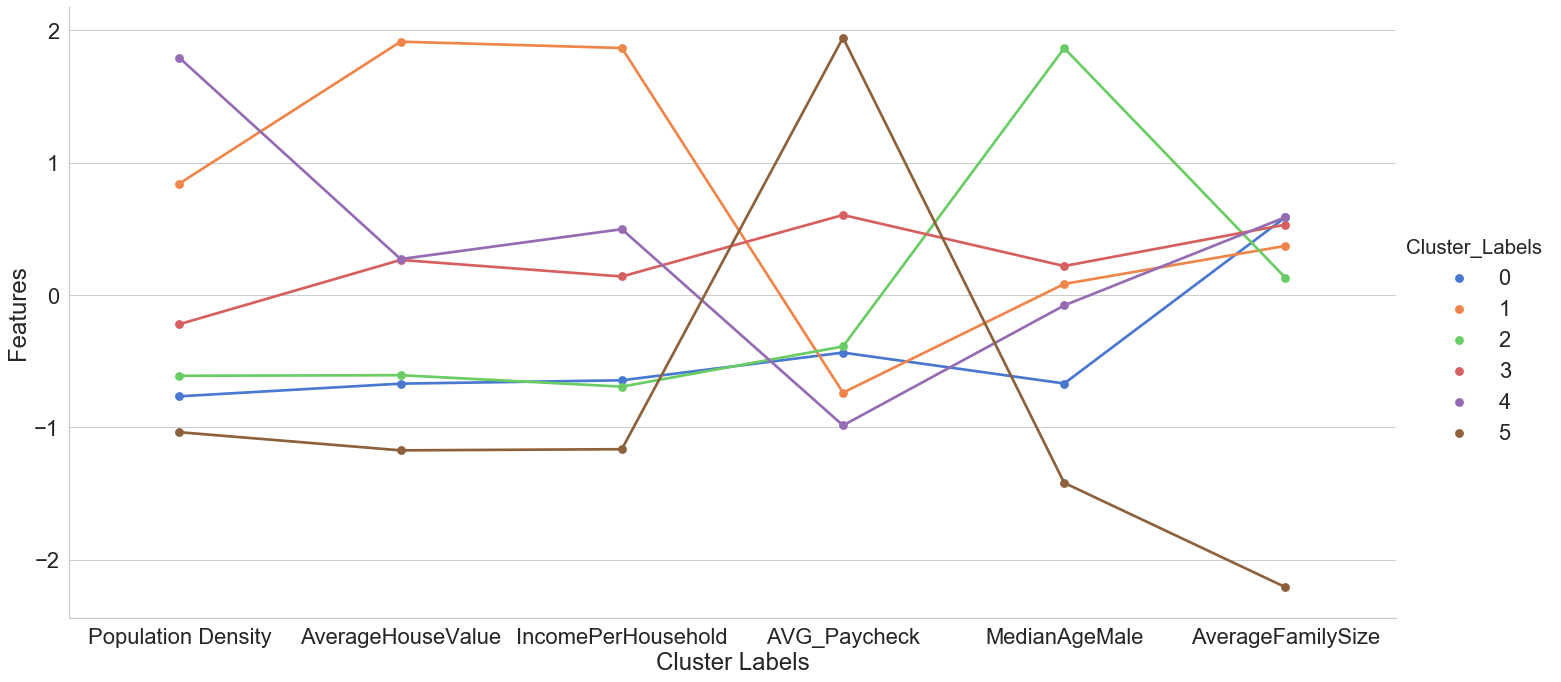

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

sns.set(style="whitegrid", palette="muted",font_scale=2)

# "Melt" the dataset to "long-form" or "tidy" representation
melted_clustered = transformed_Clustered1.melt(id_vars='Cluster_Labels', var_name='Cluster Labels', value_name='Features', col_level=None)

# Draw a categorical scatterplot to show each observation
sns.catplot(x="Cluster Labels", y="Features", hue="Cluster_Labels",
             data=melted_clustered, kind="point", height=10, aspect=2);

So now we have a visual way of interpreting our clusters.  We seek to answer the question: Which clusters would be good zip codes to locate our business?  And which clusters of zip codes should we not locate our business?

* Best Clusters:
    * Cluster 3 is the only cluster with above average house values, incomes, and high value businesses present in the zip codes.  Age is higher, and family size is lower, so I would associate this cluster with older, rich neighborhoods closer to the center of San Antonio.  Cluster 3 is clearly the best cluster overall.
    * Cluster 1 is the second most promising Cluster.  Residential Wealth is high, with AVG_paycheck being low.  Family sizes are smaller and median male ages are higher.  This cluster is most likely a rich suburb full of older professionals.
    * Cluster 4 looks like a good choice with higher incomes and home values.  Similar to cluster 1, there is dip in average paycheck which probably means this is a suburb. Male ages are lower and family size is higher than in Cluster 1.  These zip codes are most likely suburbs for younger, up-and-coming professionals.


* Okay Clusters
    * Cluster 2 looks like Zip codes full of old people living on pensions with children moved out of the house.  Except for Cluster 5 (outlier cluster), house value and incomes are low, while median age is through the roof.  Average family size is very low.  On the other hand, retired people may turn out to be a good target demographic for customers if marketed to appropriately.


* Worst Clusters:
    * Cluster 0 is below average on all measures economic vibrancy, and makes a poor cluster to locate a premium business.
    * Cluster 5 is an outlier with only one observation grouped to it.  This zipcode is probably a very small area downtown that has no meaningful residential area.  This is worst cluster of the set.

Now we can rank order our Clusters from Best to worst as 3,1,4,2,0,5. I want to visualize this data as a choropleth map, with the shading showing the most desirable zip codes by color.  But to do this, we'll have to reassign cluster labels to match our worst to best ranking because the choropleth is designed to show a continuous variable instead of discrete variables

In [23]:
newlabels = {5:1,
             0:2,
             2:3,
             4:4,
             1:5,
             3:6} #New Cluster Labels, where Higher labels indicate better zones to locate the business
updated_ZIP_demo_kmeans = ZIP_demo_kmeans.replace(to_replace=newlabels, value=None, inplace=False) #replace the labels for the dataframe for plotting
ZIPdata = ZIPdata.replace(to_replace=newlabels, value=None, inplace=False) #replace the labels in newZip df for later use

In [24]:
#because ZIP code in the JSON file is a string and they need to match for the Choropleth mapping
updated_ZIP_demo_kmeans['ZIPCode']= ZIP_demo_kmeans['ZIPCode'].astype(str)

SAmap1 = folium.Map(location=[latitude, longitude], zoom_start=9)

SAmap1.choropleth(
    geo_data='SATX_zip_codes_geo.json',
    data=updated_ZIP_demo_kmeans,
    columns=['ZIPCode','Cluster_Labels'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cluster Labels',
    reset=True,
    name='Demographic Shading',
    highlight=True
    )

folium.LayerControl().add_to(SAmap1)

SAmap1

Now that we have a map that shows favorable areas, we can do two things simultaneously:

* We can pull barbershops from Foursquare to check the validity of my above analysis, expecting to see premium barber shops located in the dark areas of the above map
* We can do a competition analysis to locate a favorable zip code for opening a new barber shop i.e. a good zip code that doesn't have a premium barber shop yet.

Let's get crackin' on the foursquare data.  I'm going to pull the name and location of all the salons and barbershops in foursquare for the Zip codes of San Antonio.  From this list, I'll have to categorize which barbershops are economical and which are boutique or premium.  From there, I can plot those places on my folium map, using different colored markers to show the category of barbershop.

In [25]:
#Defining a function to get barbershops by ZIP code

def getBarberShopsByZip(zipcodes):
    
    venues_list=[]
    for zipcode in zipcodes:
        print(' .', end='')
        
        CLIENT_ID = '1QNOLEFLTMLRHL30MQRLDFKW4GDEG3XLHBSTYJKE0CXS1I4H' # your Foursquare ID
        CLIENT_SECRET = 'AJCPBRHC3FC0EJCQJFFIJFT2A0NXOKUFNAXCZ0DHDVN0MPHX' # your Foursquare Secret
        VERSION = '20180605' # Foursquare API version
        
        #Pulled from https://developer.foursquare.com/docs/build-with-foursquare/categories/
        BarberCategoryID = '4bf58dd8d48988d110951735'  
        intent = 'match'
        LIMIT=50
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&intent={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            zipcode,
            BarberCategoryID, 
            intent,  
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # I used the below code for saving an intial JSON to figure out paths to the data I wanted
        # import json 
        # with open('foursquaretest.json', 'w', encoding='utf-8') as f:
        #    json.dump(results, f, ensure_ascii=False, indent=4)

        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode,
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])
          

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP_Searched',
                         'Venue_Name',
                         'Latitude', 
                         'Longitude']
    
    return(nearby_venues)

In [27]:
SATXbarbers = getBarberShopsByZip(zipcodes= ZIPlist)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [28]:
SATXbarbers.head(10) #all tables displayed as head(10) for cleaner HTML presentation

ZIP_Searched                  Venue_Name   Latitude  Longitude
0        78201                 Diamond Kut  29.486343 -98.557405
1        78201                 Great Clips  29.444680 -98.526214
2        78201  Fantastic Sams Cut & Color  29.489510 -98.535623
3        78201                 Great Clips  29.457068 -98.553347
4        78201              Chanty's Style  29.493290 -98.551762
5        78201          Vee's Beauty Salon  29.464011 -98.543856
6        78201        Head Rite Barbershop  29.492468 -98.526554
7        78201                  smartstyle  29.488376 -98.537103
8        78201      Gentlemen's Barbershop  29.484548 -98.559937
9        78201         Jeffrey's Hair & Co  29.489997 -98.567485

In [29]:
print(SATXbarbers.shape)

SATXbarbers.sort_values('Venue_Name',axis=0, inplace=True)
namelist = SATXbarbers['Venue_Name'].values.tolist()

(2214, 4)


So, from the above, we can tell that there are 2215 barbershops and salons in SATX.  We need to process this list to make more sense of it.
Firstly, it looks like our Foursquare API pulled duplicates as it searched by zip code.  So we'll need to eliminate the duplicates.

Also, We're interested in places where men can get their hair cut, so let's eliminate:
* Places oriented towards women or kids (Things with 'Aveda, Diva, kids, beauty, etc." in the name)
* Salons that aren't oriented towards cutting hair (Things with 'Tanning, Makeup, Nails, etc.' in the name)

Once our list contains ordinary and premium barbershops, we'll look to classify them as either economy or premium barbershops.

In [30]:
#items in our dataset to delete contain the following words.  I applied some judgement here to eliminate results that represented venues that 
# do not appeal to men including places that start with women's names, foreign words, and frilly adjectives.  
# The objective is to have a list of hair salons that men would go to.

sublist = ['Aveda', 'Diva', 'Kids','kids','kidz','Kidz', 'Cheeky', 'School',
           'beauty','Beauty','Tanning','tanning','Makeup', 'Guity', 'Ignition',
           'makeup','Nails','nails','Nails','brows','Brows','nail','Nail',
          'lash','Ana','2379 ne loop 410','glam','Glam','Extensions','extensions','4475 walzem',
          'Spa','spa','Lounge','Blow Dry','Allure','Alta','Eyebrow','eyebrow','Body','body',
           'Wax','wax','blow','Blown','Bliss', 'Young', 'Volum','Lash','lash','Anna','Regis',
          'Avalon', 'Clinic', 'Anila','Alice','Threading','Bella','Blondes','Capri','Cleo',
          'Hairbraiding','Delia','Braiding','Esmereld','De','Forever','Foxy','Skin','Beauties','Artistry',
          'le','Le', 'Lucia','Lynda','Martha','Melody','Cosmetology','Miriam','Monica','Moxie','Design',
           'Posh','Purple','Raquel','Roxana','Sajoir','Avaja','Bellezza','Snow','Sola','Sophia','Stardust',
          'Talina','Tangled','Brow','Weave','Trevi','Twirl','UCAS','Versi','Elegance','Voglia','Vogue','Car','Wigs','SPA',
          'faith','rosie','petra','mommys','Jacquelines','Color','Imago','Esmarelda','Kayla','Kouture','Medusa','Milan','Miss',
          'Neema', 'Boutique','Rene','Cadiz','Hideaway','Identity','Meraki','Platinum','Revelation','Syzygy','Hair Pieces','Neo-graft',
           'TR3S', 'Tanfastic','Tease', 'Colour','New You', "Tiffany's", "Tracy's",'Otomi','de','by JC','by jc','By JC','Neograft'
          ]

results = [] #create a list to append to
for string in sublist:   #iterate through the items in sublist
   
    res = list(filter(lambda x: string in x, namelist)) #find place names that contain keywords in our sublist
    results.append(res) #appends a list to our results list, creating a list of lists

#flatten the list of lists to a single lists
flat_results = []  
for sublist in results:
    for item in sublist:
        flat_results.append(item)
#Create a series for future iterating out of the flat list
flat_results =pd.Series(flat_results) 

#dropping the items that are filtered out of the dataframe
for item in flat_results:
    SATXbarbers.drop(SATXbarbers[SATXbarbers.Venue_Name == item].index, inplace=True)

SATXbarbers.drop('ZIP_Searched',axis=1,errors='ignore')
SATXbarbers.drop_duplicates(subset=['Latitude','Longitude'],inplace=True) #Drop the duplicates
print(SATXbarbers.shape)
SATXbarbers.reset_index(drop=True, inplace=True)
SATXbarbers.drop('index',axis=1, inplace=True, errors='ignore')
SATXbarbers.head(10) #all tables displayed as head(10) for cleaner HTML presentation

(416, 4)


ZIP_Searched                                   Venue_Name   Latitude  \
0        78249        18|8 Fine Men's Salons - Huebner Oaks  29.549378   
1        78256             18|8 Fine Men's Salons - The RIm  29.609992   
2        78215  18|8 Fine Men’s Salons - Downtown Riverwalk  29.426326   
3        78237                                50/50's Salon  29.419995   
4        78263                            AAFES Barber Shop  29.449469   
5        78234                            AAFES Barber Shop  29.457245   
6        78214               AJ's Fresh Line Up Barber Shop  29.348481   
7        78215                            Abe’s Barber Shop  29.427944   
8        78217                               Adrian Russell  29.552712   
9        78245                                   Alamo Cuts  29.433624   

   Longitude  
0 -98.581859  
1 -98.598106  
2 -98.492934  
3 -98.555680  
4 -98.454742  
5 -98.448164  
6 -98.516523  
7 -98.494135  
8 -98.468554  
9 -98.703411

Initially, we have 2414 responses, but we've narrowed down our list to 417.

At this point, we've eliminated duplicates and eliminated hair salons that cater to women based off of clues in their name.  Now, we are going to classify each barber shop as 'Premium' which means specific competition for us, or as 'Economy' which is just general competition.  We are doing this so we can map out these places and locations.  The premium places should map on our darkly shaded zip codes, and thus validate the methodology up to this point.

To label a barbershop as premium, we once again will look for hints in the name.  I then do a google search to see if the place is premium based upon unique style, availability of straight razor shaves, etc.  Another indicator of 'premium' is 2-5 locations, so that cues me to check Google for their services.

In [31]:
premium = ['Fine', "Men's", 'Matador', 'Tuneup', 'Boardroom','Champs','Diesel',
           'Downtown','Executive',"King's",'Knockouts',"Rob's",'The Art', 'Gents', 'The Barbershop',
          'The Good Barber','Tune Up', 'Manly', 'Urban', 'Urbancity', 'Veterans',"Veteran's",'all american',
          'nyc']

# This adds a premium column that indicates if a venue is premium or not

SATXbarbers['Premium'] = np.where(SATXbarbers.Venue_Name.str.contains('|'.join(premium)),'Yes','No')
SATXbarbers.head(10) #all tables displayed as head(10) for cleaner HTML presentation

ZIP_Searched                                   Venue_Name   Latitude  \
0        78249        18|8 Fine Men's Salons - Huebner Oaks  29.549378   
1        78256             18|8 Fine Men's Salons - The RIm  29.609992   
2        78215  18|8 Fine Men’s Salons - Downtown Riverwalk  29.426326   
3        78237                                50/50's Salon  29.419995   
4        78263                            AAFES Barber Shop  29.449469   
5        78234                            AAFES Barber Shop  29.457245   
6        78214               AJ's Fresh Line Up Barber Shop  29.348481   
7        78215                            Abe’s Barber Shop  29.427944   
8        78217                               Adrian Russell  29.552712   
9        78245                                   Alamo Cuts  29.433624   

   Longitude Premium  
0 -98.581859     Yes  
1 -98.598106     Yes  
2 -98.492934     Yes  
3 -98.555680      No  
4 -98.454742      No  
5 -98.448164      No  
6 -98.516523      No  
7 -98.494135      No  
8 -98.468554      No  
9 -98.703411      No

In [32]:
# Split our original dataframe into two dataframes

PremiumBarbers = SATXbarbers[SATXbarbers['Premium'] == 'Yes']
PremiumBarbers.reset_index(drop=True, inplace=True)
PremiumBarbers

EconomyBarbers = SATXbarbers[SATXbarbers['Premium'] == 'No']
EconomyBarbers.reset_index(drop=True, inplace=True)
EconomyBarbers.head(10) #all tables displayed as head(10) for cleaner HTML presentation

ZIP_Searched                      Venue_Name   Latitude  Longitude Premium
0        78237                   50/50's Salon  29.419995 -98.555680      No
1        78263               AAFES Barber Shop  29.449469 -98.454742      No
2        78234               AAFES Barber Shop  29.457245 -98.448164      No
3        78214  AJ's Fresh Line Up Barber Shop  29.348481 -98.516523      No
4        78215               Abe’s Barber Shop  29.427944 -98.494135      No
5        78217                  Adrian Russell  29.552712 -98.468554      No
6        78245                      Alamo Cuts  29.433624 -98.703411      No
7        78207         All American Barbershop  29.440421 -98.495764      No
8        78217                   All That Hair  29.536967 -98.374696      No
9        78201                       Americuts  29.487504 -98.526958      No

Now that we have a dataframe for our economy barbershops and premium barbershops, lets put markers on our map.  The aim of this is as follows:
* Seeing that the premium barbershops plot in the darker shaded ZIP codes validates the methodology of identifying good zip codes for premium barbershops
* This allows us an analyze competition visually on the map

In [33]:
newlabels = {5:1,
             0:2,
             2:3,
             4:4,
             1:5,
             3:6} #New Cluster Labels, where Higher labels indicate better zones to locate the business
newZIP = newZIP.replace(to_replace=newlabels, value=None, inplace=False) #replace the labels for the dataframe for plotting
newZIP.head(10) #all tables displayed as head(10) for cleaner HTML presentation

ZIPCode  Cluster_Labels   Latitude  Longitude  Land_Area  Population  \
0  78201.0               4  29.472779 -98.535643      7.113     45307.0   
1  78202.0               4  29.428012 -98.462994      2.325     11691.0   
2  78203.0               4  29.415274 -98.461146      1.286      6099.0   
3  78204.0               6  29.406044 -98.507786      2.639     11125.0   
4  78205.0               3  29.424324 -98.487124      1.192      1453.0   
5  78207.0               4  29.421276 -98.522055      7.327     55514.0   
6  78208.0               4  29.441178 -98.458416      0.986      3736.0   
7  78209.0               5  29.485620 -98.458175     10.186     39197.0   
8  78210.0               4  29.396556 -98.460978      7.437     36865.0   
9  78211.0               4  29.349524 -98.563594     10.278     31944.0   

   Population Density  AverageHouseValue  IncomePerHousehold  \
0         6369.604949             7757.0             16314.0   
1         5028.387097             1886.0              3848.0   
2         4742.612753              948.0              1976.0   
3         4215.611974             2440.0              4279.0   
4         1218.959732              149.0               949.0   
5         7576.634366             7274.0             15351.0   
6         3789.046653              539.0              1552.0   
7         3848.124877            10239.0             17823.0   
8         4956.971897             6700.0             12469.0   
9         3107.997665             5890.0              9157.0   

   Number_of_Businesses  Business_Employment  LocalBusinessPayroll  \
0                 814.0              15356.0              504533.0   
1                 144.0               1826.0               60560.0   
2                  60.0                752.0               28287.0   
3                 237.0               5634.0              360739.0   
4                1230.0              28240.0             1193668.0   
5                 646.0              13687.0              492830.0   
6                  80.0               1389.0               45358.0   
7                1761.0              27284.0             1011749.0   
8                 315.0               3559.0              109925.0   
9                 321.0               5153.0              169166.0   

   AVG_Paycheck  MedianAge  MedianAgeMale  MedianAgeFemale  AverageFamilySize  
0     32.855757       35.6           33.9             37.3               3.45  
1     33.165389       31.3           30.4             32.4               3.76  
2     37.615691       29.8           29.1             30.7               3.74  
3     64.028931       35.9           34.4             37.7               3.50  
4     42.268697       52.3           50.4             57.6               2.41  
5     36.007160       30.1           29.8             30.5               3.76  
6     32.655148       35.6           35.7             35.5               3.50  
7     37.082136       41.3           39.3             43.1               2.91  
8     30.886485       33.7           32.3             34.9               3.49  
9     32.828644       31.2           29.7             32.8               3.77

In [34]:
import folium
from folium import plugins
import os

SAmap2 = folium.Map(location=[latitude, longitude], zoom_start=10)

SAmap2.choropleth(
    geo_data='SATX_zip_codes_geo.json',
    data=updated_ZIP_demo_kmeans,
    columns=['ZIPCode','Cluster_Labels'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cluster Labels',
    reset=True,
    name='Demographic Shading',
    highlight=True
    )

# add markers to show ZIP codes
# Create a layer for the ZIP code labels
fg1 = folium.FeatureGroup(name='ZIP Code Labels')
SAmap2.add_child(fg1)
# Create the ZIP code markers/labels and add to the feature group
for lat, lng, postalcode, cluster in zip(newZIP.Latitude.astype('float'),
                                        newZIP.Longitude.astype('float'),
                                        newZIP.ZIPCode.astype('int'),
                                        newZIP.Cluster_Labels):
    
    label = '{},{}'.format(postalcode,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(fg1) 

# add markers to show Premium Barbershops
# Create a layer for the Premium Barbershops
fg2 = folium.FeatureGroup(name='Premium Barbershops')
SAmap2.add_child(fg2)
# Create the Premium Barbershop markers and add to the feature group
for lat, lng, venue in zip(PremiumBarbers.Latitude.astype('float'), PremiumBarbers.Longitude.astype('float'), PremiumBarbers['Venue_Name']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(fg2) 
    
# Create a layer for the Economy Barbershops
fg3 = folium.FeatureGroup(name='Economy Barbershops')
SAmap2.add_child(fg3)
# Create the Economy Barbershop markers and add to the feature group
for lat, lng, venue in zip(EconomyBarbers.Latitude.astype('float'), EconomyBarbers.Longitude.astype('float'), EconomyBarbers['Venue_Name']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(fg3) 

folium.LayerControl().add_to(SAmap2)

#Save our created map
delay=5
fn = 'SATX_Barbershops.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
SAmap2.save(fn)

SAmap2

Awesome!!! Now we have a map for human visual analysis.  This map has layers for de-cluttering, so along with the zoom feature we should be able to deduce quite a lot from this product.

## Analysis <a name="analysis"></a>

General Observations and efficacy of the model: Cluster 5 by far houses the highest number of premium barbershops which means that, subjectively, the k-means clustering seemed to work.  Furthermore, a simple majority of the premium barbershops are adjacent to Cluster 6 zip codes.  This goes to show that applying some basic demographic and economic data at scale and then working backwards to interpret the Clusters produced a map model that provides useful insight against the business problem.  This largely validates our methodology.

Observation 1: There are very few premium barbershops in our darkest clusters (which is meant to highlight suitability for a premium barbershop).  However, many premium barbershops appear to be located on the edge of these dark clusters so that hints that these areas may still be associated with customers.  It may also be the case that not all the dark clusters are not well classified and that there is high variability within the cluster.  Lastly, it could be that rents are very high in these areas for businesses that are prohibitively high for even premium barbershops.  We'll look more closely into Cluster 6 to attempt to explain this observation.

Observation 2: The most promising Zip code for starting a new premium barbershop appears to be 78222, which is the along the San Antonio outer loop.  It's a cluster 6 area adjacent to a cluster 4 and cluster 5.  Also, The second most promising Zip code would be 78250, which is a cluster 5 zip code adjacent to 5 other cluster 5 zip codes.

Areas of Further Analysis: 
* We'll look at the zipcodes in Cluster 6 ('Darkest) to see how high the variability in these zip codes are.  If all the zip codes in this cluster are clustered tightly, this would tell us that a factor that our model doesn't account for is likely preventing formation of premium barbershop businesses in these zip codes.
* We'll look more closely into Zip codes 78222 and 78250 to check their suitability for a premium barbershop.  We will attempt to discover if there is a reason that isn't apparent in our visual model why these places are not well served by a premium barbershop already by looking more closely at the data.  Or **these zip codes might represent undiscovered opportunities** for entrepreneurs seeking to open a premium barbershop.

#### Cluster 6 Further Analysis

In [35]:
Cluster6 = updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['Cluster_Labels'] == 6] #Cluster 6 zip data
Cluster6AVG = Cluster6.groupby('Cluster_Labels').mean().reset_index()  #create a row of average cluster data for comparision
Cluster6med = Cluster6.groupby('Cluster_Labels').median().reset_index() #create a row of median cluster data for comparision
# Add the 3 dataframes together
Cluster6df = pd.concat([Cluster6,Cluster6AVG]).reset_index()
Cluster6df.iloc[8,1] = 'AVG CL6'
Cluster6df2 = pd.concat([Cluster6df,Cluster6med]).reset_index()
Cluster6df2.iloc[9,2] = 'MED CL6'
Cluster6df2.drop(['level_0','index','Cluster_Labels'],axis=1,errors='ignore',inplace=True)

<Figure size 1440x720 with 0 Axes>

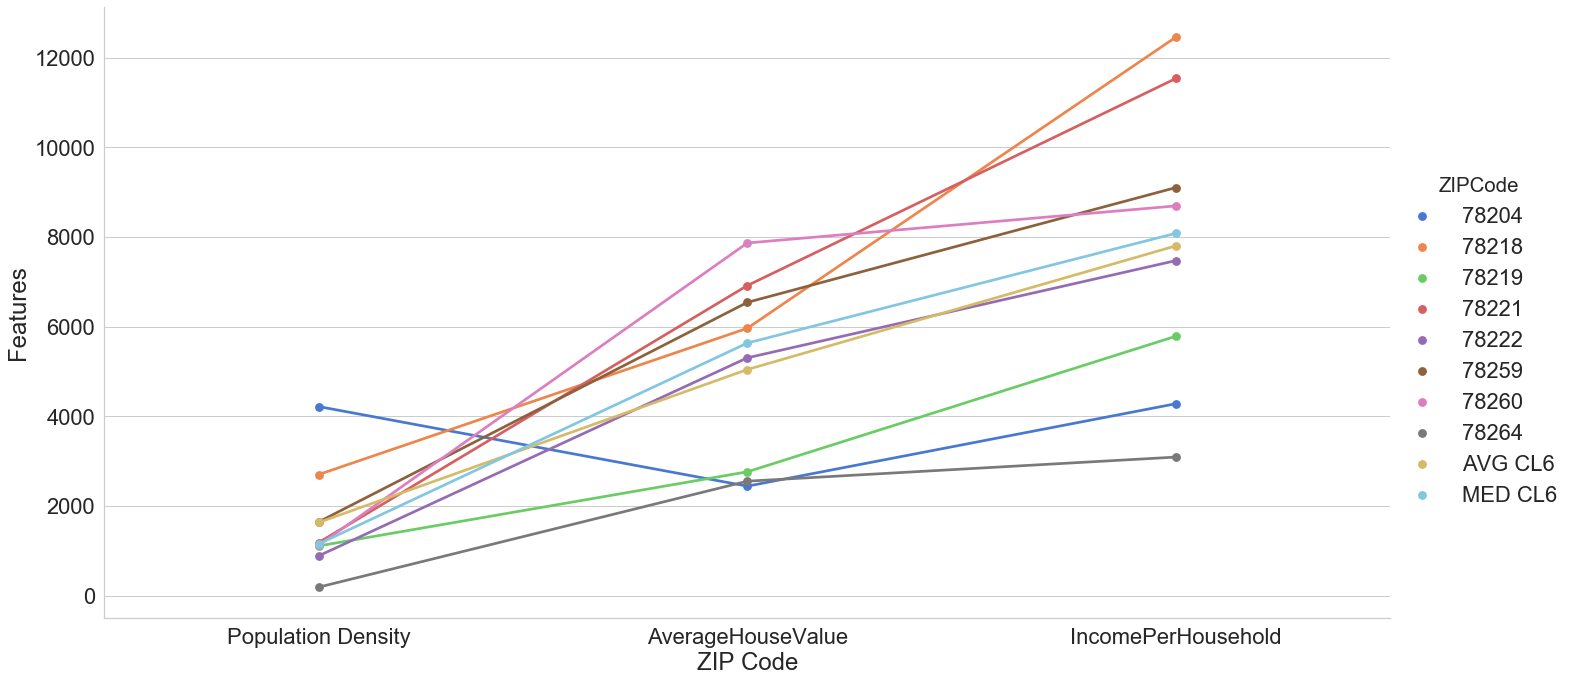

In [36]:
Cluster6df2.drop(['MedianAgeMale','AverageFamilySize','AVG_Paycheck'],axis=1,errors='ignore',inplace=True)

plt.figure(figsize=(20,10))

sns.set(style="whitegrid", palette="muted",font_scale=2)

# "Melt" the dataset to "long-form" or "tidy" representation
melted_clustered = Cluster6df2.melt(id_vars='ZIPCode', var_name='ZIP Code', value_name='Features', col_level=None)

# Draw a categorical scatterplot to show each observation
sns.catplot(x="ZIP Code", y="Features", hue="ZIPCode",
             data=melted_clustered, kind="point", height=10, aspect=2);

Looking at the above graph, we can observe that 78219 (Eastside by Army Heliport), 78264 (Southern Exurb), and 78204 (Downtown) are outliers within Cluster 6.  

Because of the presence of these outliers, we can conclude that a feature not present in our model is effecting the formation of premium barbershops in Cluster 6 Zip codes, and we also know that the 3 zip codes described above are not in fact good places to locate a premium barbershop.

Additionally, the orange line in the graph above cues us to look more closely at zip code 78218.  Looking at the map, there are 3 premium barbershops in adjacent zip codes, but none in the actual zip code itself.  

**78218 might be a great zip code to locate a new premium barbershop.**

#### Zip Code 78222 Further Analysis

Zip code 78222 is the purple line in the above graph.  This location looks mediocre now that we've seen its stats more closely.

#### Zip Code 78250 Further Analysis

The last target area of interest is 78250 located in the western part of the city.  The adjacent zip codes to 78250 are 78254, 78251, 78253,78240.

In [37]:
updated_ZIP_demo_kmeans['ZIPCode'].astype(str)

SAwest = pd.DataFrame(None)
SAwest = SAwest.append(updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['ZIPCode'] == '78250'])
SAwest = SAwest.append(updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['ZIPCode'] == '78254'])
SAwest = SAwest.append(updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['ZIPCode'] == '78251'])
SAwest = SAwest.append(updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['ZIPCode'] == '78253'])
SAwest = SAwest.append(updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['ZIPCode'] == '78240'])


SAwest

ZIPCode  Population Density  Cluster_Labels  AverageHouseValue  \
46   78250         5717.275851               5            14269.0   
50   78254         1656.575737               5            13622.0   
47   78251         3258.949173               5            11026.0   
49   78253          533.972719               5            10359.0   
38   78240         4510.722796               5             8391.0   

    IncomePerHousehold  AVG_Paycheck  MedianAgeMale  AverageFamilySize  
46             18794.0     23.046207           31.0               3.32  
50             17020.0     27.802424           30.1               3.40  
47             20144.0     40.741292           29.4               3.35  
49             12812.0     23.430484           32.2               3.40  
38             23610.0     36.388237           30.4               2.99

In [38]:
Cluster5 = updated_ZIP_demo_kmeans[updated_ZIP_demo_kmeans['Cluster_Labels'] == 5]
Cluster5avg = Cluster5.groupby('Cluster_Labels').mean().reset_index()
Cluster5avg

Cluster_Labels  Population Density  AverageHouseValue  IncomePerHousehold  \
0               5         3096.033751            10821.0           18122.125   

   AVG_Paycheck  MedianAgeMale  AverageFamilySize  
0     36.993105       32.39375               3.21

In [39]:
try: del SAwest1
except: None
SAwest1 = pd.concat([SAwest,Cluster5avg]).reset_index()
SAwest1.drop(['index','Cluster_Labels'],axis=1,errors='ignore',inplace=True)
SAwest1.iloc[5,0] = 'Cluster 5 Average'
SAwest1

ZIPCode  Population Density  AverageHouseValue  \
0              78250         5717.275851            14269.0   
1              78254         1656.575737            13622.0   
2              78251         3258.949173            11026.0   
3              78253          533.972719            10359.0   
4              78240         4510.722796             8391.0   
5  Cluster 5 Average         3096.033751            10821.0   

   IncomePerHousehold  AVG_Paycheck  MedianAgeMale  AverageFamilySize  
0           18794.000     23.046207       31.00000               3.32  
1           17020.000     27.802424       30.10000               3.40  
2           20144.000     40.741292       29.40000               3.35  
3           12812.000     23.430484       32.20000               3.40  
4           23610.000     36.388237       30.40000               2.99  
5           18122.125     36.993105       32.39375               3.21

<Figure size 1440x720 with 0 Axes>

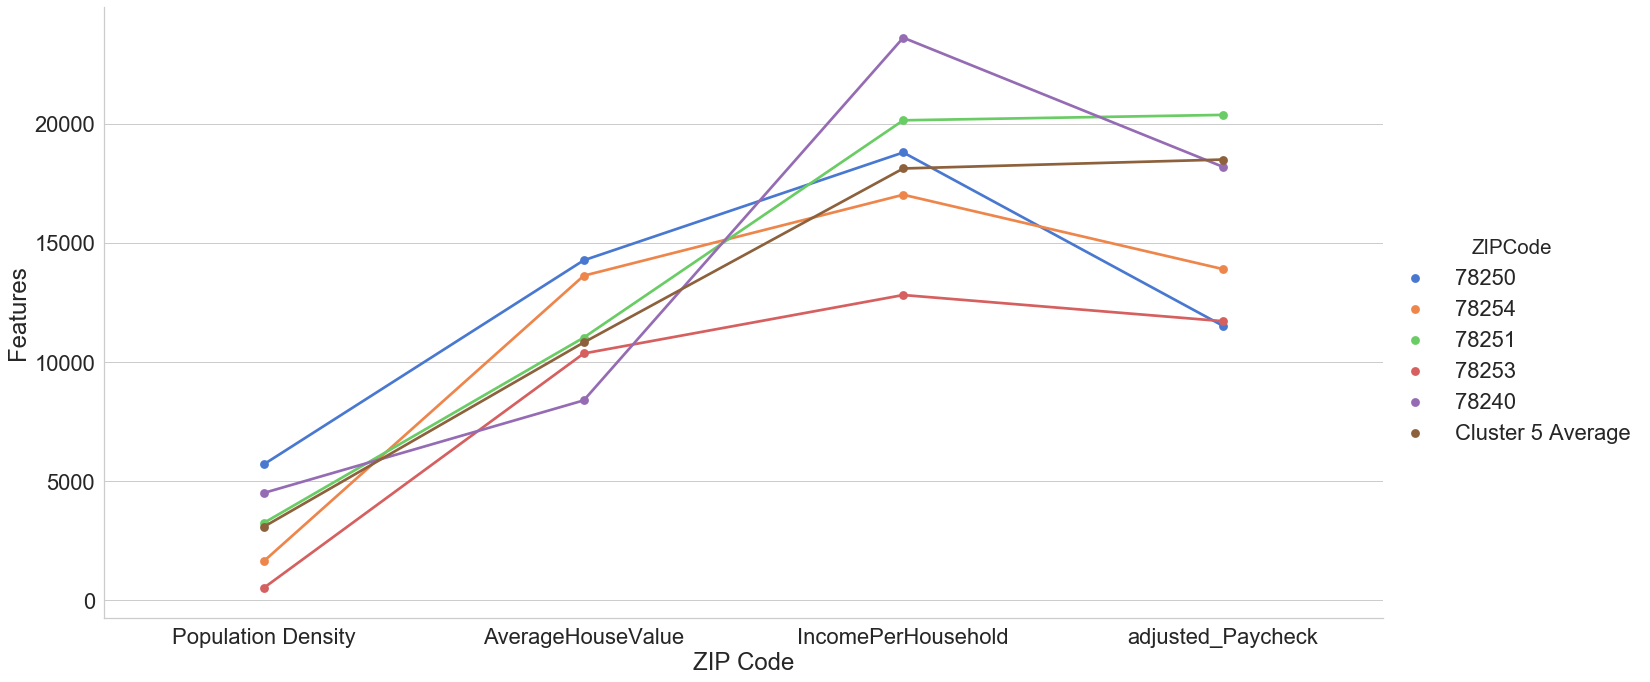

In [40]:
SAwest1['adjusted_Paycheck'] = SAwest1['AVG_Paycheck'].map(lambda x: x*500)

SAwest2 = SAwest1.drop(['MedianAgeMale','AverageFamilySize','AVG_Paycheck'],axis=1,errors='ignore',inplace=False)

plt.figure(figsize=(20,10))

sns.set(style="whitegrid", palette="muted",font_scale=2)

# "Melt" the dataset to "long-form" or "tidy" representation
melted_clustered = SAwest2.melt(id_vars='ZIPCode', var_name='ZIP Code', value_name='Features', col_level=None)

# Draw a categorical scatterplot to show each observation
sns.catplot(x="ZIP Code", y="Features", hue="ZIPCode",
             data=melted_clustered, kind="point", height=10, aspect=2);

Only one of the 5 zip codes has below average values for Cluster 5.  Because 78250 is in the middle of our cluster 5 zip codes, it looks like a great place to open a premium barbershop.  

The mitigating factor with this location though is that there is some competition in the adjacent area, but none in the immediate zip code itself.

## Results and Discussion <a name="results"></a>

78218 and 78250 and their surrounding areas are the best places to open a premium barbershop.  Of course, this analysis does not include street level knowledge, knowledge of local business rents, or availability of commercial zoned space for rent.  

## Conclusion <a name="conclusion"></a>

This data-driven study set out to solve a problem for premium barbershop entrepreneurs: Where should I set up my next shop?  Along the way, this study also was able to provide answers for, “Where is my competition located?”  The results of this study have narrowed down the search area that an entrepreneur would need to do from a city of 61 zip codes to 2 prospective zip codes, saving time and providing value to the entrepreneur.  Of course, this study doesn’t account for all variables that go into opening a business in a certain location, but it does make finding the right place easier.  